# GNN_goal_recognizer


## Installations and import

In [1]:
#pip install torch_geometric
#pip install wandb -qU
#pip install networkx==3.4.2
#pip install torchinfo

In [2]:
# --- 1. Python Standard Library ---
import json
import math
import os
import pprint
import random
from dataclasses import dataclass
from typing import List, Tuple

# --- 2. Third-Party Scientific & Utilities ---
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import wandb
from sklearn.manifold import TSNE

# --- 3. PyTorch Core ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

# --- 4. PyTorch Geometric (GNNs) & Scatter ---
# Data handling
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx, softmax as pyg_softmax

# Neural Network Layers
from torch_geometric.nn import GCNConv

# Scatter operations (often needed for custom aggregations)
from torch_scatter import scatter_max, scatter_sum, scatter_mean

/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
'''
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # per multi-GPU
    # Assicura determinismo negli algoritmi di convoluzione (può rallentare un po')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Seed set to {seed}")

# Utilizzo
set_seed(42)
'''

'\ndef set_seed(seed: int = 42):\n    random.seed(seed)\n    np.random.seed(seed)\n    torch.manual_seed(seed)\n    torch.cuda.manual_seed(seed)\n    torch.cuda.manual_seed_all(seed)  # per multi-GPU\n    # Assicura determinismo negli algoritmi di convoluzione (può rallentare un po\')\n    torch.backends.cudnn.deterministic = True\n    torch.backends.cudnn.benchmark = False\n    os.environ["PYTHONHASHSEED"] = str(seed)\n    print(f"Seed set to {seed}")\n\n# Utilizzo\nset_seed(42)\n'

## Utils

In [4]:
# Helper Functions for Visualization
def visualize_graph(
    title,
    G,
    color,
    labels=None,
    train_mask=None,
    pred_mask=None,
    node_feature=False,
    edge_attr=None,
    node_size=100,
    img_size=(8, 8)
):
    # Aggiungi pesi agli archi se presenti
    if edge_attr is not None:
        for i, (u, v) in enumerate(G.edges()):
            G[u][v]['weight'] = edge_attr[i].item() if hasattr(edge_attr[i], 'item') else edge_attr[i]

    plt.figure(figsize=img_size)
    plt.title(title)

    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(
        G, pos, with_labels=node_feature,
        node_size=node_size, node_color=color, cmap="Set2"
    )

    # Evidenzia goal reali (train_mask)
    if train_mask is not None:
        nx.draw_networkx_nodes(
            G, pos=pos,
            nodelist=[i for i, t in enumerate(train_mask) if t],
            node_color=[c for c, t in zip(color, train_mask) if t],
            cmap="Set2", edgecolors='red', linewidths=2, node_size=node_size
        )

    # Evidenzia goal predetto (pred_mask)
    if pred_mask is not None:
        nx.draw_networkx_nodes(
            G, pos=pos,
            nodelist=[i for i, t in enumerate(pred_mask) if t],
            node_color=[c for c, t in zip(color, pred_mask) if t],
            cmap="Set2", edgecolors='lime', linewidths=3, node_size=node_size
        )

    # Disegna etichette degli archi (se ci sono pesi)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    if len(edge_labels) > 0:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Legenda
    legend_handles = []
    legend_labels = []

    if train_mask is not None and any(train_mask):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markeredgecolor='red', markersize=10, label='Goal reale'))
        legend_labels.append('Goal reale')
    if pred_mask is not None and any(pred_mask):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markeredgecolor='lime', markersize=10, label='Goal predetto'))
        legend_labels.append('Goal predetto')

    if legend_handles:
        plt.legend(handles=legend_handles, loc='upper right')

    plt.show()


def visualize_embedding(title, h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.legend(handles=scatter.legend_elements()[0], labels=labels.values())
    plt.show()

## Classes

### Map

In [5]:
@dataclass
class Map:
    V: List[List[Tuple[int, int, int]]]
    E: List[Tuple[int, int]]
    Y: List[List[int]]
    O: List[List[int]]
    Optimality: List[float]
    AvgLength: float
    ObstaclePerc: float

In [6]:
class MyDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super().__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

    @property
    def num_features(self):
        return self[0].num_node_features

    @property
    def num_classes(self):
        y_all = torch.cat([d.y for d in self])
        return int(y_all.max().item() + 1)

### MapLoader

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

def load_maps_from_drive_unified(type,size):
    """
    Carica tutte le istanze di Map insieme dal file unified
    Restituisce una lista di oggetti Map.
    """
    if size not in [8, 16, 32, 128]:
        print("size deve essere 16, 32 o 128")
        return []

    all_maps = []
    #file_path = f"/content/drive/MyDrive/Progetto_deep_learning/Dataset/{type}{size}.json"
    file_path = f"{type}{size}.json"
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        print(f"File {i} non trovato o non leggibile")
        return None

    if not data:
        print(f"File {i} vuoto")
        return None



    all_maps.extend([Map(**map_dict) for map_dict in data])

    return all_maps


## Creation and loading of the dataset

In [8]:
class GoalRecognitionDataset(Dataset):
    def __init__(self, maps, transform=None):
        """
        maps: lista di mappe (con la griglia + edge_index già costruito)
        paths: lista di percorsi (ogni percorso è lista di nodi [src, ..., goal])
        """
        super().__init__(None, transform)
        self.maps = maps

    '''
    @percentage è la percentuale di percorso che passo al metodo, cioè quanto è lungo il percorso delle varie entries
    prima generavamo tutti i percorsi aumentati di uno alla volta, ora posso scegliere quanto farlo lungo
    '''
    def generate_entries(self,map_index, path_index,print_or_not, percentage=100):
        """
        Genera le entry per ogni sottopercorso (minimo 2 elementi) di un path di O.
        Ogni entry è (V_mod, E, Y).
        """
        entries = []

        len_entr = len(self.maps[map_index].O[path_index])
        new_len = int((100-percentage)*len_entr/100)
        if new_len < 2:
          new_len = 2
        #for step in range(2, len(self.maps[map_index].O[path_index])+1):
        for step in range(new_len, len_entr+1):
            V_mod = [row.copy() for row in self.maps[map_index].V[path_index]]

            visited = self.maps[map_index].O[path_index][:step-1]         # nodi già visitati
            agent_pos = self.maps[map_index].O[path_index][step-1]        # posizione attuale
            future = self.maps[map_index].O[path_index][step:]            # nodi futuri -> liberi

            if(print_or_not):
              print(visited)

            for v in visited:
                V_mod[v] = [0,0,1]

            V_mod[agent_pos] = [0,1,0]

            for f in future:
                V_mod[f] = [1,0,0]

            x = torch.tensor(V_mod, dtype=torch.float)
            edge_index = torch.tensor(self.maps[map_index].E, dtype=torch.long).t().contiguous()


            y = torch.tensor(self.maps[map_index].Y[path_index], dtype=torch.float)

            # Esponenziazione per aumentare il contrasto
            alpha = 1.0
            y_transformed = y ** alpha

            # Normalizza di nuovo
            y_transformed = y_transformed / y_transformed.sum()

            # Ora puoi usarlo come target
            entries.append(Data(x=x, edge_index=edge_index, y=y_transformed))

        return entries

    def generate_all_entries(self):
        """
        Genera tutte le entry per tutti i percorsi di tutte le mappe.
        """
        entries = []

        for map in range(len(self.maps)):
            for path in range(len(self.maps[map].O)):
                for entry in self.generate_entries(map, path,False, 100): #30 da modificare se voglio sottopercorsi più o meno lunghi
                    entries.append(entry)

        return entries

CARICA TUTTE LE MAPPE

In [9]:
size=8
maps=load_maps_from_drive_unified("DfsRandomJump",size)

In [10]:
goalRecognitionDataset = GoalRecognitionDataset(maps)
dataset = goalRecognitionDataset.generate_all_entries()

# Suddivisione in train / val / test (80% / 10% / 10%)
total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len   = int(0.1 * total_len)
test_len  = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Logging WanDB


In [11]:
wandb.login(key="38de765b09e71e9b6b33218b7ade62f2349d81c0")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/deeplearning/.netrc
wandb: Currently logged in as: m-lizza002 (m-lizza002-university-of-brescia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Sweeps

### Define a sweep

In [12]:
parameters_dict = {
    # --- Ottimizzazione ---
    'optimizer': {
        'values': ['Adam']  # Solo Adam, SGD non va bene qui
    },
    'learning_rate': {
        # Cerca valori tra 0.0001 e 0.005 (logaritmico)
        'distribution': 'log_uniform_values',
        'min': 0.001,
        'max': 0.01
    },
    'batch_size': {
        'values': [32, 64] # 32 è un buon compromesso
    },
    'epochs': {
        'value': 15
    },

    # --- Architettura ---
    'num_layers': {
        # Testiamo reti poco profonde (2) vs profonde (4, 6)
        'values': [2, 4, 6]
    },
    'hidden_channels': {
        # Unica dimensione per tutti i layer interni per semplicità
        'values': [64, 128]
    },
    'dropout': {
        'values': [0.0, 0.2, 0.4]
    }
}

In [13]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_topk',
        'goal': 'maximize'
    },
    'parameters': parameters_dict
    }

In [14]:
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_topk'},
 'parameters': {'batch_size': {'values': [32, 64]},
                'dropout': {'values': [0.0, 0.2, 0.4]},
                'epochs': {'value': 15},
                'hidden_channels': {'values': [64, 128]},
                'learning_rate': {'distribution': 'log_uniform_values',
                                  'max': 0.01,
                                  'min': 0.001},
                'num_layers': {'values': [2, 4, 6]},
                'optimizer': {'values': ['Adam']}}}


### Initialize the Sweep

In [15]:
sweep_id = wandb.sweep(sweep_config, project="Node_Classificator")

Create sweep with ID: coklwsg7
Sweep URL: https://wandb.ai/m-lizza002-university-of-brescia/Node_Classificator/sweeps/coklwsg7


## Training


### Node Classificator

In [16]:
SAVE_DIR = "./gnn/"
MODEL_NAME = "node_cls_soft.pth"

# Dizionario per salvare i migliori parametri globalmente
best_params = {}

class NodeClassificator(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout=0.0):
        super(NodeClassificator, self).__init__()
        
        self.dropout_p = dropout
        self.convs = nn.ModuleList()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        # Costruzione dinamica dei layer GCN
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.relu(x)
            x = self.dropout(x)
        
        # Restituisce LOGITS (punteggi non normalizzati) per stabilità numerica
        logits = self.lin(x).squeeze(-1)
        return logits

    # ------------------------------- TRAINING --------------------------------

    def train_gcn(self, train_loader, val_loader, optimizer, device, num_epochs, patience=10):
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6, verbose=True
        )

        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        # Parametro per lo smoothing: 0.2 significa che i vicini del goal prendono peso
        neighbor_weight = 0.2
        k_val=10

        for epoch in range(num_epochs):
            self.train()
            total_loss = 0
            train_top1_hits = 0
            train_topk_hits = 0
            total_graphs = 0

            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()

                # 1. Ottieni Logits
                logits = self(batch.x, batch.edge_index, batch.batch)
                
                # 2. Calcola Log-Probabilità (Stabile) e Probabilità
                # Calcoliamo softmax manualmente in log-space per stabilità: log(softmax(x))
                probs = pyg_softmax(logits, batch.batch)
                log_probs = torch.log(probs + 1e-15)

                # 3. Topological Target Smoothing
                # Spalmiamo la probabilità del target sui vicini nel grafo
                target = batch.y.float()
                
                # Prende il target dei nodi vicini e fa la media per ogni nodo
                # edge_index[1] è sorgente (o dest in base al flusso), edge_index[0] è nodo corrente
                target_neighbors = scatter_mean(target[batch.edge_index[1]], batch.edge_index[0], dim=0)
                
                # Mix tra target puro (One-Hot) e target dei vicini
                smooth_target = (1 - neighbor_weight) * target + neighbor_weight * target_neighbors

                # 4. Calcolo Loss con Target Smooth
                loss = scatter_sum(-smooth_target * log_probs, batch.batch).mean()

                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # --- CALCOLO METRICHE TRAIN (Ora con Top-K) ---
                # Dobbiamo iterare sui grafi del batch anche qui
                num_graphs_batch = batch.num_graphs
                for i in range(num_graphs_batch):
                    mask = batch.batch == i
                    sub_probs = probs[mask]
                    sub_target = target[mask] # Target originale per le metriche
                    
                    true_goal_idx = sub_target.argmax().item()
                    
                    # Train Top-1
                    if sub_probs.argmax().item() == true_goal_idx:
                        train_top1_hits += 1
                    
                    # Train Top-K
                    curr_k = min(k_val, len(sub_probs))
                    _, top_k_indices = sub_probs.topk(curr_k)
                    if true_goal_idx in top_k_indices.tolist():
                        train_topk_hits += 1

                total_graphs += num_graphs_batch

            # Medie per epoca
            avg_train_loss = total_loss / len(train_loader)
            avg_train_top1 = train_top1_hits / total_graphs
            avg_train_topk = train_topk_hits / total_graphs

            # Validazione (Top-1 e Top-K)
            val_loss, val_top1, val_topk = self.eval_gcn(val_loader, device, k=k_val)

            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]['lr']

            print(f"Epoch {epoch:03d} | LR: {current_lr:.6f} | "
                  f"Loss (train/val): {avg_train_loss:.4f}/{val_loss:.4f} | "
                  f"Top1 (train/val): {avg_train_top1:.2%}/{val_top1:.2%} | "
                  f"Top{k_val} (train/val): {avg_train_topk:.2%}/{val_topk:.2%}")
            
            if wandb.run is not None:
                wandb.log({
                    "epoch": epoch, "lr": current_lr,
                    "train_loss": avg_train_loss, "train_top1": avg_train_top1, "train_topk": avg_train_topk,
                    "val_loss": val_loss, "val_top1": val_top1, "val_topk": val_topk
                })

            # Checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                
                best_params.update({
                    'optimizer': optimizer.__class__.__name__,
                    'dropout': self.dropout_p,
                    'epochs': epoch,
                    'learning_rate': optimizer.param_groups[0]['lr'],
                    'batch_size': getattr(train_loader.dataset, 'batch_size', None) if hasattr(train_loader, 'dataset') else train_loader.batch_size,
                    'num_layers': len(self.convs),
                    'hidden_channels': self.convs[0].out_channels,
                    'in_channels': self.convs[0].in_channels
                })

                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR, exist_ok=True)
                run_id = wandb.run.id if wandb.run else "manual"
                MODEL_NAME = f"model_{run_id}.pth"    
                torch.save(self.state_dict(), os.path.join(SAVE_DIR, MODEL_NAME))
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    @torch.no_grad()
    def eval_gcn(self, loader, device, k=3):
        self.eval()
        total_loss = 0
        total_top1 = 0
        total_topk = 0
        total_graphs = 0
        
        for batch in loader:
            batch = batch.to(device)
            
            # Forward (Logits -> Probs)
            logits = self(batch.x, batch.edge_index, batch.batch)
            probs = pyg_softmax(logits, batch.batch)
            log_probs = torch.log(probs + 1e-15)
            
            target = batch.y.float() # Target reale per validazione

            # Loss standard
            loss = scatter_sum(-target * log_probs, batch.batch).mean()
            total_loss += loss.item()
            
            # Calcolo Metriche per Grafo
            num_graphs = batch.num_graphs
            for i in range(num_graphs):
                mask = batch.batch == i
                sub_probs = probs[mask]
                sub_target = target[mask]
                
                true_goal_idx = sub_target.argmax().item()
                
                # Top-1
                if sub_probs.argmax().item() == true_goal_idx:
                    total_top1 += 1
                    
                # Top-K
                curr_k = min(k, len(sub_probs))
                _, top_k_indices = sub_probs.topk(curr_k)
                
                if true_goal_idx in top_k_indices.tolist():
                    total_topk += 1
            
            total_graphs += num_graphs
            
        return total_loss / len(loader), total_top1 / total_graphs, total_topk / total_graphs

In [17]:
def train_sweep(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config

        # Nome run più descrittivo
        run_name = (
            f"Adam"
            f"-L{config.num_layers}"     # Numero di Layer
            f"-H{config.hidden_channels}" # Dimensione Hidden
            f"-lr{config.learning_rate:.4f}"
            f"-bs{config.batch_size}"
        )
        run.name = run_name

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # --- Inizializzazione Modello Dinamico ---
        model = NodeClassificator(
            in_channels=3, # (Visitato, Agente, Futuro) - Assumendo sia fisso a 3
            hidden_channels=config.hidden_channels,
            num_layers=config.num_layers, # <--- Parametro nuovo
            dropout=config.dropout
        ).to(device)

        # Optimizer
        optimizer = getattr(optim, config.optimizer)(
            model.parameters(), lr=config.learning_rate
        )

        # Training
        model.train_gcn(
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=config.epochs,
            patience=10 # Un po' di pazienza in più per i LR bassi
        )

        print("BEST PARAMS:", best_params)

In [ ]:
#sweep_id = "coklwsg7"

if wandb.run is not None:
    wandb.finish()

wandb.agent(sweep_id, function=train_sweep, count=5)

wandb: Agent Starting Run: qc4fywb5 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.008477811118920604
wandb: 	num_layers: 2
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.008478 | Loss (train/val): 3.9245/3.9114 | Top1 (train/val): 6.15%/6.30% | Top10 (train/val): 33.37%/34.18%
Epoch 001 | LR: 0.008478 | Loss (train/val): 3.9235/3.9108 | Top1 (train/val): 6.12%/6.39% | Top10 (train/val): 33.29%/32.56%
Epoch 002 | LR: 0.008478 | Loss (train/val): 3.9232/3.9109 | Top1 (train/val): 6.13%/6.17% | Top10 (train/val): 33.43%/33.78%
Epoch 003 | LR: 0.008478 | Loss (train/val): 3.9233/3.9109 | Top1 (train/val): 6.19%/6.13% | Top10 (train/val): 33.31%/33.61%
Epoch 004 | LR: 0.008478 | Loss (train/val): 3.9232/3.9103 | Top1 (train/val): 6.01%/6.11% | Top10 (train/val): 33.51%/34.01%
Epoch 005 | LR: 0.008478 | Loss (train/val): 3.9231/3.9119 | Top1 (train/val): 6.15%/5.90% | Top10 (train/val): 33.42%/34.30%
Epoch 006 | LR: 0.008478 | Loss (train/val): 3.9227/3.9123 | Top1 (train/val): 6.12%/6.43% | Top10 (train/val): 33.56%/31.04%
Epoch 007 | LR: 0.008478 | Loss (train/val): 3.9226/3.9096 | Top1 (train/val): 6.05%/6.24% | Top10 (train/val): 33.37%

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▄▄▄▂▂▂▁▁▂▁▁▁
train_top1,▇▆▆█▃▇▆▄▇▄▂▃▁▂▃
train_topk,▃▁▄▁▆▄▇▃███▄▅▅▅
val_loss,▆▅▅▅▃▇█▂▁▂▁▁▂▄▃
val_top1,▇█▅▅▅▂█▆▅▇▅▁▅▅▄
val_topk,█▄▇▇▇█▁▅▇▄▄▇▆▆▇
epoch,14
lr,0.00848
train_loss,3.92233


wandb: Agent Starting Run: cbd297ku with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_channels: 128
wandb: 	learning_rate: 0.0018998311107038736
wandb: 	num_layers: 2
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.001900 | Loss (train/val): 3.9228/3.9097 | Top1 (train/val): 6.31%/6.51% | Top10 (train/val): 33.14%/33.13%


wandb: Ctrl + C detected. Stopping sweep.


: 

In [ ]:
print(best_params)

{'epochs': 26, 'val_loss': 3.8925183537614894, 'val_top1': 0.05995156751096276, 'val_topk': 0.3792132992996924}


In [ ]:
#print(model)


In [ ]:
# --- 1. Configurazione e Recupero della Best Run ---
api = wandb.Api()

# Inserisci il percorso del tuo sweep (lo trovi su wandb.ai o nell'output della cella dello sweep)
# Esempio: "nome-utente/nome-progetto/ID-sweep"
SWEEP_PATH = "m-lizza002-university-of-brescia/Node_Classificator/sweeps/coklwsg7" 
sweep = api.sweep(SWEEP_PATH)

# Ottieni la run migliore in base alla metrica definita nello sweep (es. val_acc o val_loss)
best_run = sweep.best_run()
best_run_id = best_run.id
best_config = best_run.config

print(f"Best Run ID identificata: {best_run_id}")
print(f"Iperparametri: Hidden={best_config['hidden_channels']}, Layers={best_config['num_layers']}")


# --- 2. Costruzione del nome file e Percorso ---
MODEL_NAME = f"model_{best_run_id}.pth"
SAVE_DIR = "./gnn/"
model_path = os.path.join(SAVE_DIR, MODEL_NAME)


# --- 3. Istanziazione e Caricamento ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Istanzio il modello con i parametri della BEST run
model_test = NodeClassificator(
    in_channels=3, 
    hidden_channels=best_config['hidden_channels'], 
    num_layers=best_config['num_layers'], 
    dropout=0.0 # Dropout sempre 0 per il test/inferenza
).to(device)

if os.path.exists(model_path):
    print(f"📂 Trovato file dei pesi: {model_path}")
    # Carica lo stato
    model_test.load_state_dict(torch.load(model_path, map_location=device))
    model_test.eval()
    print("✅ Modello caricato correttamente!")
    
    # --- 4. Esecuzione del Test ---
    test_loss, test_top1, test_topk = model_test.eval_gcn(test_loader, device, k=10)

    print(f"\nRISULTATI TEST FINALI (Run {best_run_id}):")
    print(f"---------------------------------------")
    print(f"Test Loss       : {test_loss:.4f}")
    print(f"Test Top-1 Acc  : {test_top1:.2%}")
    print(f"Test Top-10 Acc : {test_topk:.2%}")

else:
    print(f" ERRORE: Il file {model_path} non esiste nella directory locale.")
    print("Assicurati di aver eseguito il training su questa macchina o di aver scaricato i pesi.")


--- INIZIO TEST SU DATI NON VISTI ---
Caricamento pesi da: ./gnn/node_cls_soft.pth


/tmp/ipykernel_722192/999667460.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for NodeClassificator:
	Unexpected key(s) in state_dict: "convs.3.bias", "convs.3.lin.weight". 
	size mismatch for convs.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for convs.0.lin.weight: copying a param with shape torch.Size([128, 3]) from checkpoint, the shape in current model is torch.Size([64, 3]).
	size mismatch for convs.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for convs.1.lin.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for convs.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for convs.2.lin.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for lin.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([1, 64]).

In [ ]:
# scegli device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mapIndex=80 
pathIndex=8
goalRecognitionDataset = GoalRecognitionDataset(maps)
map_and_paths= goalRecognitionDataset.generate_entries(mapIndex,pathIndex,True)

[48, 49, 42, 41, 34, 35, 27, 20, 19]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25, 24]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25, 24, 32]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25, 24, 32, 31]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25, 24, 32, 31, 23]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25, 24, 32, 31, 23, 22]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25, 24, 32, 31, 23, 22, 15]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25, 24, 32, 31, 23, 22, 15, 16]
[48, 49, 42, 41, 34, 35, 27, 20, 19, 26, 25, 24, 32, 31, 23, 22, 15, 16, 17]


--- Visualizzazione Percorso 8 su Mappa 80 ---

Step 0 | Probabilità sul nodo predetto (16): 0.0218 | Goal Reale: 18


/tmp/ipykernel_722192/1048288110.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


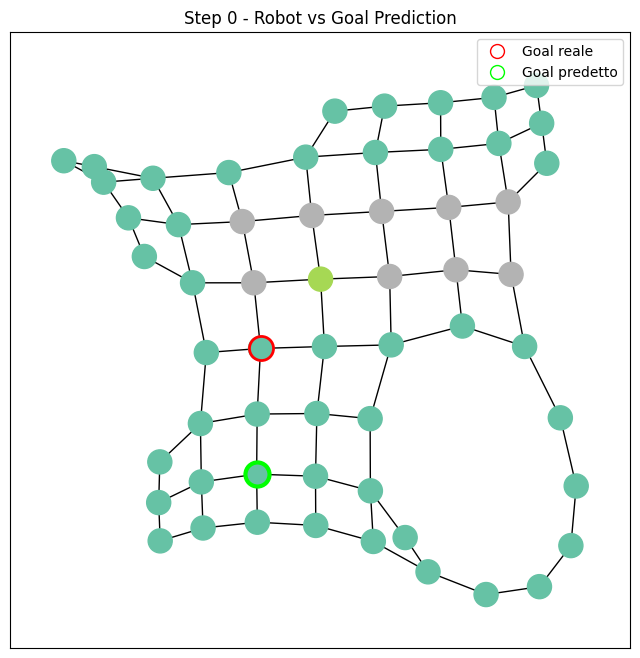

Step 1 | Probabilità sul nodo predetto (8): 0.0215 | Goal Reale: 18


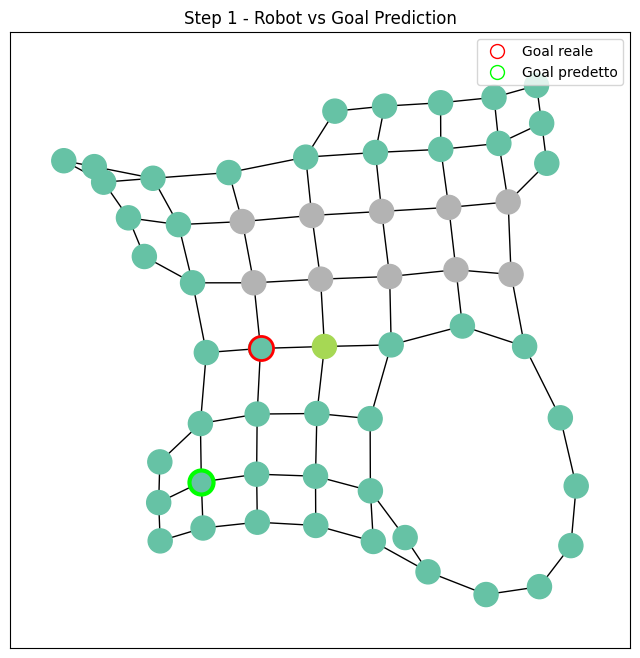

Step 2 | Probabilità sul nodo predetto (23): 0.0202 | Goal Reale: 18


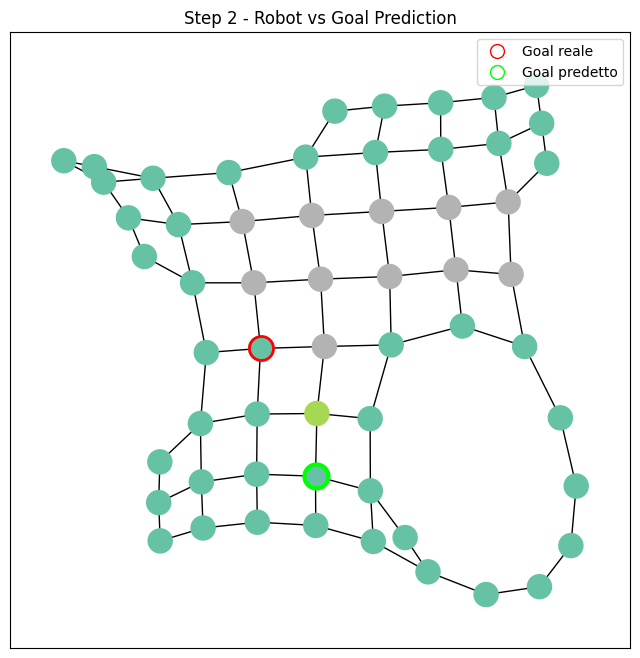

Step 3 | Probabilità sul nodo predetto (31): 0.0218 | Goal Reale: 18


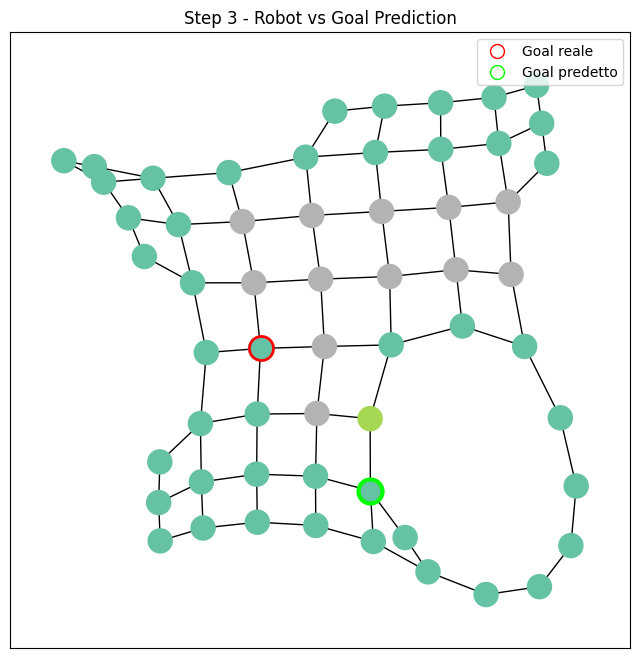

Step 4 | Probabilità sul nodo predetto (31): 0.0216 | Goal Reale: 18


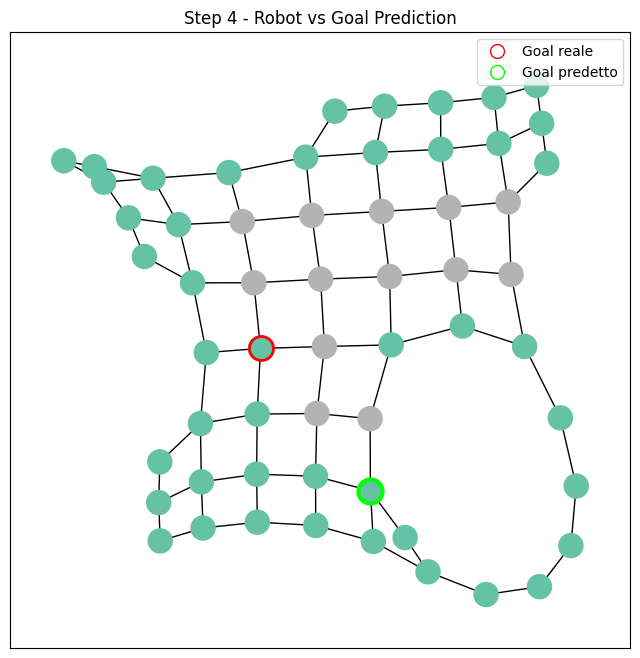

Step 5 | Probabilità sul nodo predetto (16): 0.0211 | Goal Reale: 18


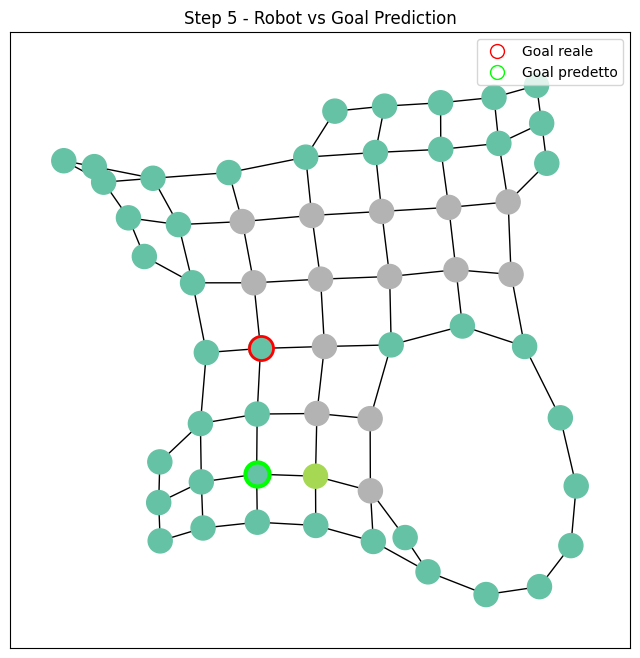

Step 6 | Probabilità sul nodo predetto (52): 0.0207 | Goal Reale: 18


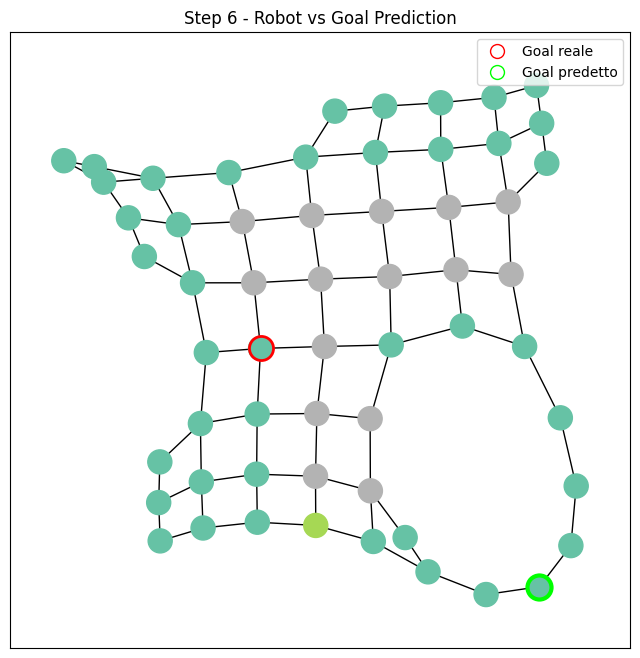

Step 7 | Probabilità sul nodo predetto (8): 0.0229 | Goal Reale: 18


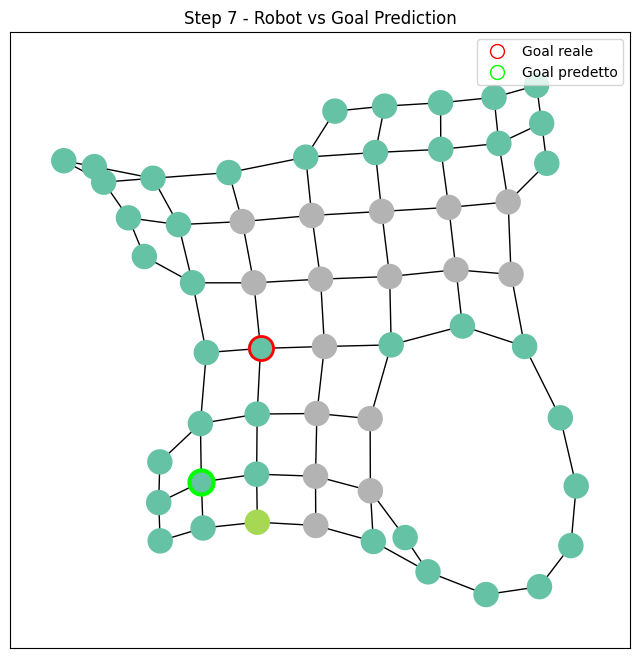

Step 8 | Probabilità sul nodo predetto (8): 0.0220 | Goal Reale: 18


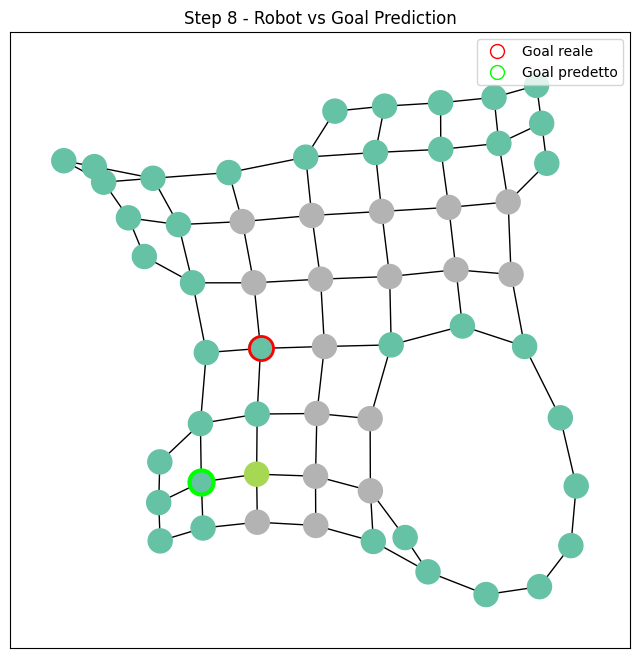

Step 9 | Probabilità sul nodo predetto (9): 0.0226 | Goal Reale: 18


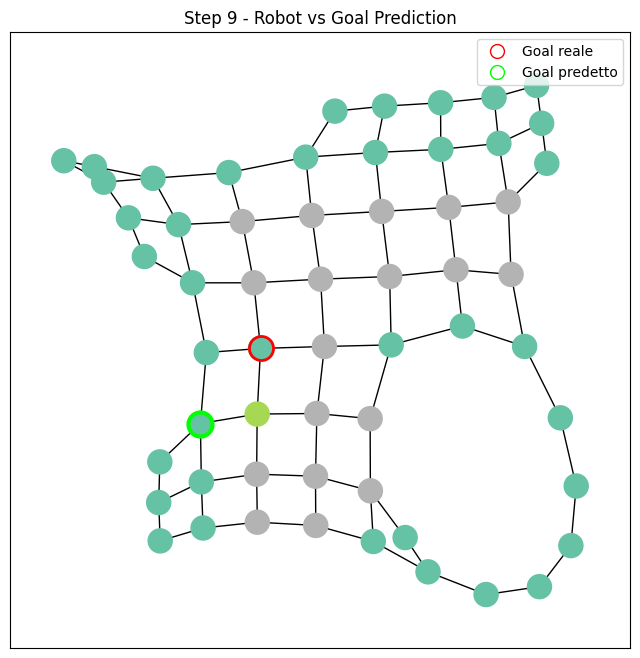

Step 10 | Probabilità sul nodo predetto (11): 0.0228 | Goal Reale: 18


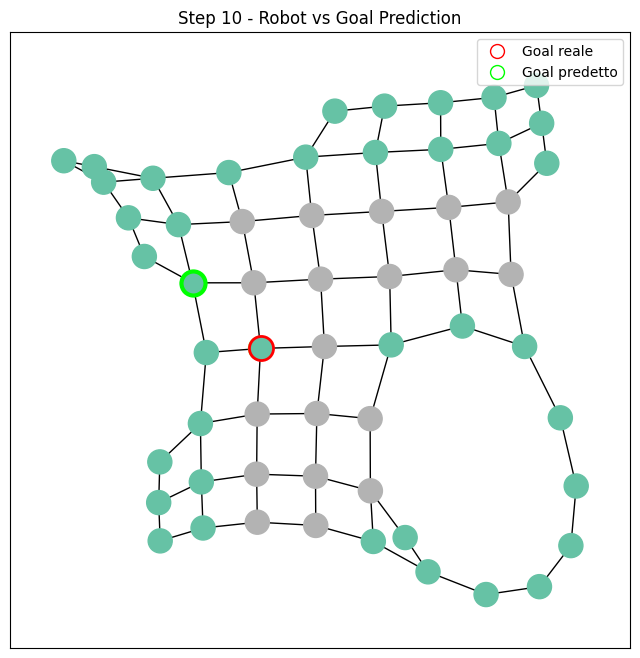

Numero predizioni 11
Goals predetti (indici):
[16, 8, 23, 31, 31, 16, 52, 8, 8, 9, 11]

Lunghezza percorso reale: 20


In [ ]:
#Inizializzazione corretta con i nuovi parametri dinamici
best_model = NodeClassificator(
    in_channels=best_params.get('in_channels', 3), 
    hidden_channels=best_params['hidden_channels'], # Ora è un valore singolo
    num_layers=best_params['num_layers'],           # Nuovo parametro
    dropout=best_params['dropout']
).to(device)

# Carica i pesi
MODEL_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.eval()

resulted_goals = []

print(f"--- Visualizzazione Percorso {pathIndex} su Mappa {mapIndex} ---\n")

for i, paths in enumerate(map_and_paths):
    data = paths.to(device)
    
    with torch.no_grad():
        # Batch index fittizio per un singolo grafo
        batch_index = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
        
        # Forward pass (restituisce probabilità)
        probs = best_model(data.x, data.edge_index, batch_index)

    # Output cleaning
    probs = probs.squeeze() # Toglie dimensioni extra
    
    # --- Identificazione Goal Predetto ---
    pred_idx = probs.argmax().item()
    resulted_goals.append(pred_idx)
    
    # --- Identificazione Goal Reale (Ground Truth) ---
    # Nota: Se data.y è una heatmap, prendiamo l'indice col valore più alto come "Vero Goal"
    # per disegnarlo col bordo rosso. Usare > 0.5 potrebbe fallire se la heatmap è "sfocata".
    true_goal_idx = data.y.argmax().item()
    
    # Creazione Maschere per Visualizzazione
    # Maschera Predizione (Verde)
    predicted_mask = np.zeros(data.num_nodes, dtype=bool)
    predicted_mask[pred_idx] = True
    
    # Maschera Verità (Rosso)
    true_goal_mask = np.zeros(data.num_nodes, dtype=bool)
    true_goal_mask[true_goal_idx] = True

    # --- Preparazione Colori Nodi ---
    # Prendiamo solo i primi 3 canali (Free, Agent, Visited) per decidere il colore di base
    # Ignoriamo le coordinate (canali 3 e 4) per la colorazione
    node_states = torch.argmax(data.x[:, :3], dim=1).cpu().numpy()

    # Conversione a NetworkX
    G = to_networkx(data, to_undirected=True)

    print(f"Step {i} | Probabilità sul nodo predetto ({pred_idx}): {probs[pred_idx]:.4f} | Goal Reale: {true_goal_idx}")

    visualize_graph(
        f"Step {i} - Robot vs Goal Prediction",
        G,
        color=node_states,
        train_mask=true_goal_mask,  # Bordo ROSSO (Vero Goal)
        pred_mask=predicted_mask,   # Bordo VERDE (Predizione)
        node_size=300
    )

print(f"Numero predizioni {len(resulted_goals)}")
print(f"Goals predetti (indici):\n{resulted_goals}\n")

# Verifica lunghezza percorso originale
# Nota: maps[mapIndex] deve essere accessibile qui
if 'maps' in locals():
    print(f"Lunghezza percorso reale: {len(maps[mapIndex].O[pathIndex])}")

In [ ]:
"""

best_model = NodeClassificator(
    in_channels=best_params['in_channels'],
    hidden_channels_1=best_params['hidden_channels_1'],
    hidden_channels_2=best_params['hidden_channels_2'],
    linear_channels=best_params['linear_channels'],
    dropout=best_params['dropout']
).to(device)

MODEL_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.eval()

resulted_goals = []
resulted_paths = []

print("\n--- INIZIO PREDIZIONE PROGRESSIVA ---\n")

for i, data in enumerate(map_and_paths):
    data = data.to(device)

    # Nodo iniziale del robot (posizione corrente)
    current_node = torch.argmax(data.x[:, 1]).item()
    visited_nodes = set([current_node])
    predicted_path = [current_node]

    print(data)

    print(f"\n🗺️  Mappa {i+1}/{len(map_and_paths)} - Nodo iniziale: {current_node}")

    while True:
        # --- Aggiorna feature dei nodi ---
        x_updated = data.x.clone()
        x_updated[:, 1] = 0               # reset posizione robot
        x_updated[current_node, 1] = 1    # nodo corrente = posizione robot
        for v in visited_nodes:
            x_updated[v, 0] = 1           # nodi visitati

        # --- Predizione del goal ---
        with torch.no_grad():
            out = best_model(x_updated, data.edge_index)
            probs = torch.sigmoid(out).squeeze().cpu()

        # Maschera nodi già visitati
        probs_masked = probs.clone()
        for v in visited_nodes:
            probs_masked[v] = -float('inf')

        # Se tutti i nodi sono stati visitati → fine
        if torch.all(probs_masked == -float('inf')):
            print("⚠️  Tutti i nodi visitati, fermo qui.")
            break

        # Nodo predetto come prossimo o goal
        pred_idx = probs_masked.argmax().item()
        pred_prob = probs[pred_idx].item()

        # Aggiorna stato
        visited_nodes.add(pred_idx)
        predicted_path.append(pred_idx)
        current_node = pred_idx

        # Se la probabilità è abbastanza alta → goal trovato
        if pred_prob > 0.5:
            print(f"🏁 Goal trovato nel nodo {pred_idx} con prob {pred_prob:.4f}")
            resulted_goals.append(pred_idx)
            break

    resulted_paths.append(predicted_path)

    # Visualizza grafo del risultato finale
    G = to_networkx(data, to_undirected=True)
    node_states = torch.argmax(x_updated, dim=1).cpu().numpy()
    predicted_mask = np.zeros(len(node_states), dtype=bool)
    predicted_mask[predicted_path[-1]] = True
    is_goal = data.y.cpu().numpy() > 0.5

    visualize_graph(
        f"Graph - Predizione finale mappa {i+1}",
        G,
        color=node_states,
        train_mask=is_goal,
        pred_mask=predicted_mask,
        node_size=300
    )

print("\n--- RISULTATI FINALI ---")
for i, (goal, path) in enumerate(zip(resulted_goals, resulted_paths)):
    print(f"Mappa {i+1}: Goal predetto = {goal}, Lunghezza percorso = {len(path)}")
    """
